# Обнаружение мошеннических операций с кредитными картами

## Постановка задачи
Кредитные компании стремятся автоматизировать процесс обнаружения мошеннических транзакций в режиме реального времени для защиты клиентов от несанкционированных списаний. Для этого предоставлен набор данных, содержащий транзакции по кредитным картам за два дня, включающий 284,807 операций, из которых 492 являются мошенническими.

## Описание данных
Набор данных содержит следующие признаки:

### Исходные признаки (без преобразования PCA):
- **Time**: Время в секундах, прошедшее между данной транзакцией и первой транзакцией в наборе данных
- **Amount**: Сумма транзакции

### Преобразованные признаки (результат PCA):
- **V1-V28**: 28 главных компонент, полученных в результате анализа главных компонент (PCA)

### Целевая переменная:
- **Class**: Метка класса (1 - мошенническая операция, 0 - легитимная операция)

## Особенности данных
- **Сильный дисбаланс классов**: Мошеннические операции составляют всего 0.172% от общего числа транзакций
- **Конфиденциальность**: Исходные признаки недоступны из-за соображений конфиденциальности
- **Временные метки**: Данные содержат временные характеристики транзакций

## Метрики оценки
В связи с сильным дисбалансом классов рекомендуется использовать:
- **Area Under the Precision-Recall Curve (AUPRC)** - основная метрика
- **Precision** и **Recall** для класса мошеннических операций
- **F1-score** для положительного класса
- **Confusion Matrix** для визуализации результатов  
Accuracy не является информативной метрикой для данной задачи из-за высокой несбалансированности данных.

## 0. Imports

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    precision_recall_curve, 
    average_precision_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve
)

## 1. EDA

#### 1.1 Изучение структуры датасета

In [101]:
df = pd.read_csv('creditcard.csv')
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
df.info() # Смотрим на описание столбцов в помощью pandas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

#### 1.2 Проверка качества данных

В данных пропусков нет, данные числовые, причем получены через PCA, больший интерес вызывали признаки Time и Amount, но в них тоже пропусков нет

In [12]:
sum(df.isnull().sum())

0

#### 1.3 Описательная стастистика признаков

**Анализ числовых признаков**

In [15]:
# Основные статистики для Amount и Time
amount_stats = df[['Time', 'Amount']].describe()
print("Статистики для Time и Amount:")
print(amount_stats)

Статистики для Time и Amount:
                Time         Amount
count  284807.000000  284807.000000
mean    94813.859575      88.349619
std     47488.145955     250.120109
min         0.000000       0.000000
25%     54201.500000       5.600000
50%     84692.000000      22.000000
75%    139320.500000      77.165000
max    172792.000000   25691.160000


**Особенности PCA-признаков**

In [21]:
# Все PCA признаки имеют среднее около 0 и std около 1 (стандартизированы)
pca_columns = [f'V{i}' for i in range(1, 29)]
pca_stats = df[pca_columns].describe().T[['mean', 'std', 'min', 'max']]
print("\nСтатистики PCA признаков:")
print(pca_stats)


Статистики PCA признаков:
             mean       std         min         max
V1   1.175161e-15  1.958696  -56.407510    2.454930
V2   3.384974e-16  1.651309  -72.715728   22.057729
V3  -1.379537e-15  1.516255  -48.325589    9.382558
V4   2.094852e-15  1.415869   -5.683171   16.875344
V5   1.021879e-15  1.380247 -113.743307   34.801666
V6   1.494498e-15  1.332271  -26.160506   73.301626
V7  -5.620335e-16  1.237094  -43.557242  120.589494
V8   1.149614e-16  1.194353  -73.216718   20.007208
V9  -2.414189e-15  1.098632  -13.434066   15.594995
V10  2.238554e-15  1.088850  -24.588262   23.745136
V11  1.724421e-15  1.020713   -4.797473   12.018913
V12 -1.245415e-15  0.999201  -18.683715    7.848392
V13  8.238900e-16  0.995274   -5.791881    7.126883
V14  1.213481e-15  0.958596  -19.214325   10.526766
V15  4.866699e-15  0.915316   -4.498945    8.877742
V16  1.436219e-15  0.876253  -14.129855   17.315112
V17 -3.768179e-16  0.849337  -25.162799    9.253526
V18  9.707851e-16  0.838176   -9.4987

#### 1.4 Визуальный анализ распределений

Видим сильный дизбаланс по целевой переменной, это проблема, которую нужно решить. Различных методов много, **эксперименты с ними я вывел в отдельном файле**. Здесь только самый эффективный метод - class_weight.

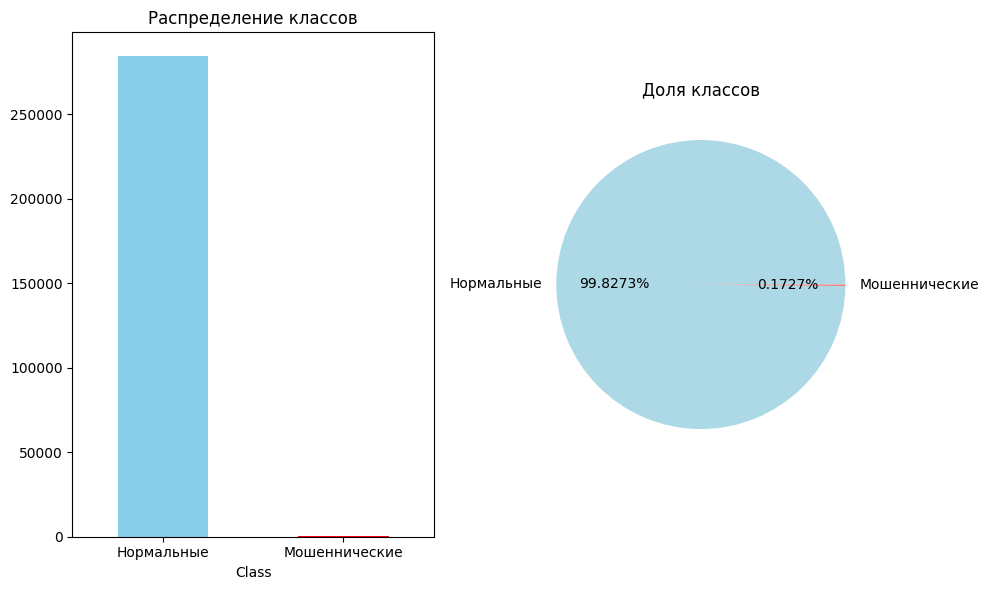

In [20]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df['Class'].value_counts().plot(kind='bar', color=['skyblue', 'red'])
plt.title('Распределение классов')
plt.xticks([0, 1], ['Нормальные', 'Мошеннические'], rotation=0)

plt.subplot(1, 2, 2)
plt.pie(df['Class'].value_counts(), labels=['Нормальные', 'Мошеннические'], 
        autopct='%1.4f%%', colors=['lightblue', 'lightcoral'])
plt.title('Доля классов')

plt.tight_layout()
plt.show()

**Распределение суммы транзакций**

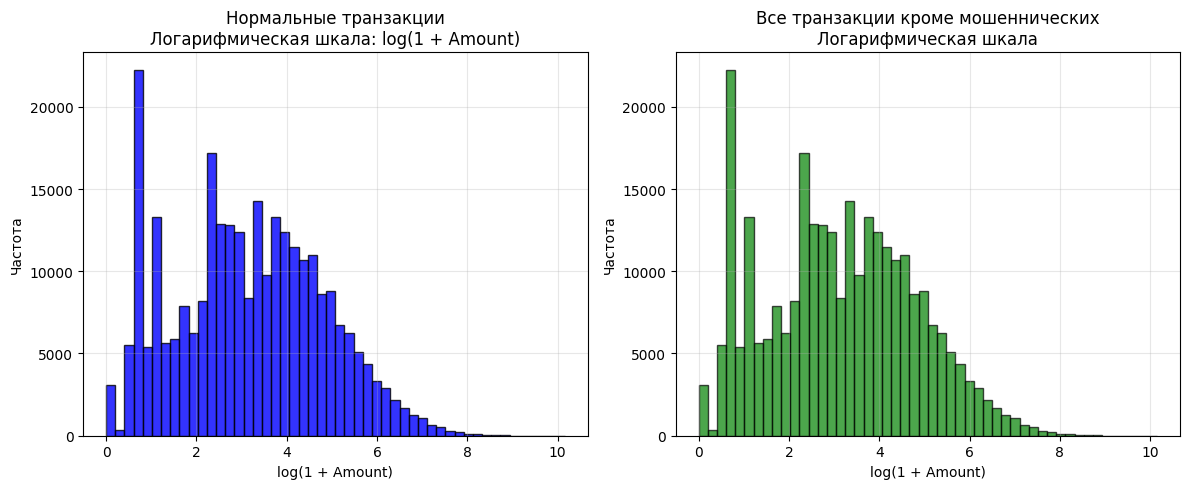

In [45]:
plt.figure(figsize=(12, 5))

# Только нормальные транзакции (логарифмическая шкала)
plt.subplot(1, 2, 1)
normal_amounts_log = np.log1p(df[df['Class'] == 0]['Amount'])
plt.hist(normal_amounts_log, bins=50, color='blue', alpha=0.8, edgecolor='black')
plt.title('Нормальные транзакции\nЛогарифмическая шкала: log(1 + Amount)')
plt.xlabel('log(1 + Amount)')
plt.ylabel('Частота')
plt.grid(alpha=0.3)

# Для контекста: все транзакции кроме мошеннических (логарифмическая шкала)
plt.subplot(1, 2, 2)
non_fraud_log = np.log1p(df[df['Class'] == 0]['Amount'])
plt.hist(non_fraud_log, bins=50, color='green', alpha=0.7, edgecolor='black')
plt.title('Все транзакции кроме мошеннических\nЛогарифмическая шкала')
plt.xlabel('log(1 + Amount)')
plt.ylabel('Частота')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

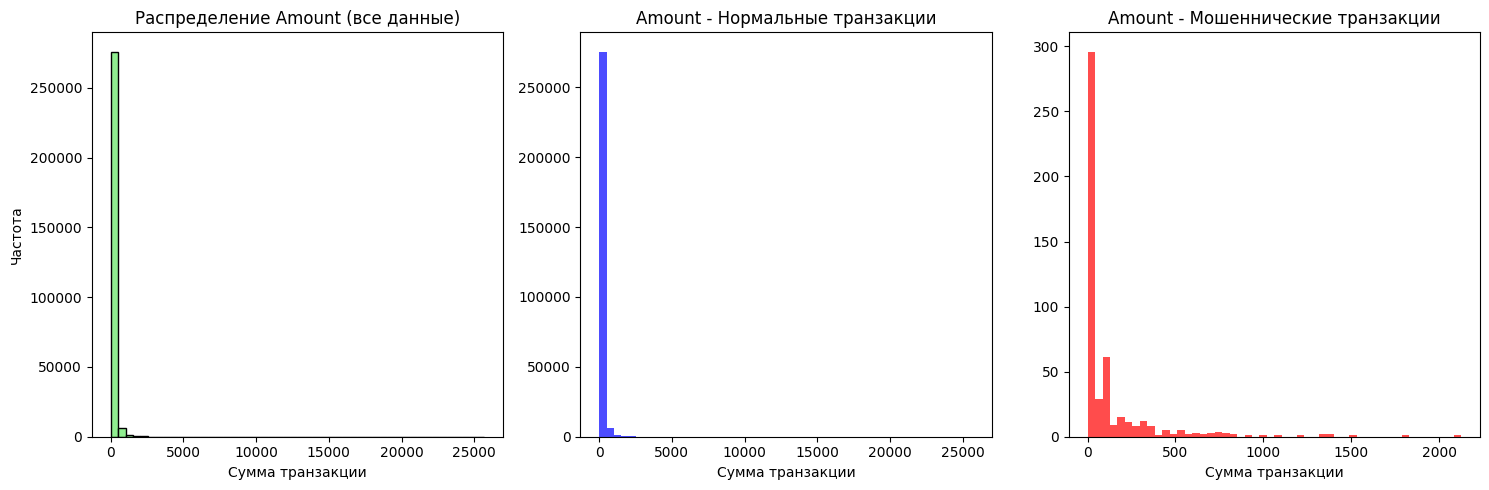

In [44]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['Amount'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Распределение Amount (все данные)')
plt.xlabel('Сумма транзакции')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
plt.hist(df[df['Class'] == 0]['Amount'], bins=50, color='blue', alpha=0.7, label='Нормальные')
plt.title('Amount - Нормальные транзакции')
plt.xlabel('Сумма транзакции')

plt.subplot(1, 3, 3)
plt.hist(df[df['Class'] == 1]['Amount'], bins=50, color='red', alpha=0.7, label='Мошеннические')
plt.title('Amount - Мошеннические транзакции')
plt.xlabel('Сумма транзакции')

plt.tight_layout()
plt.show()

**Анализ времени транзакций**

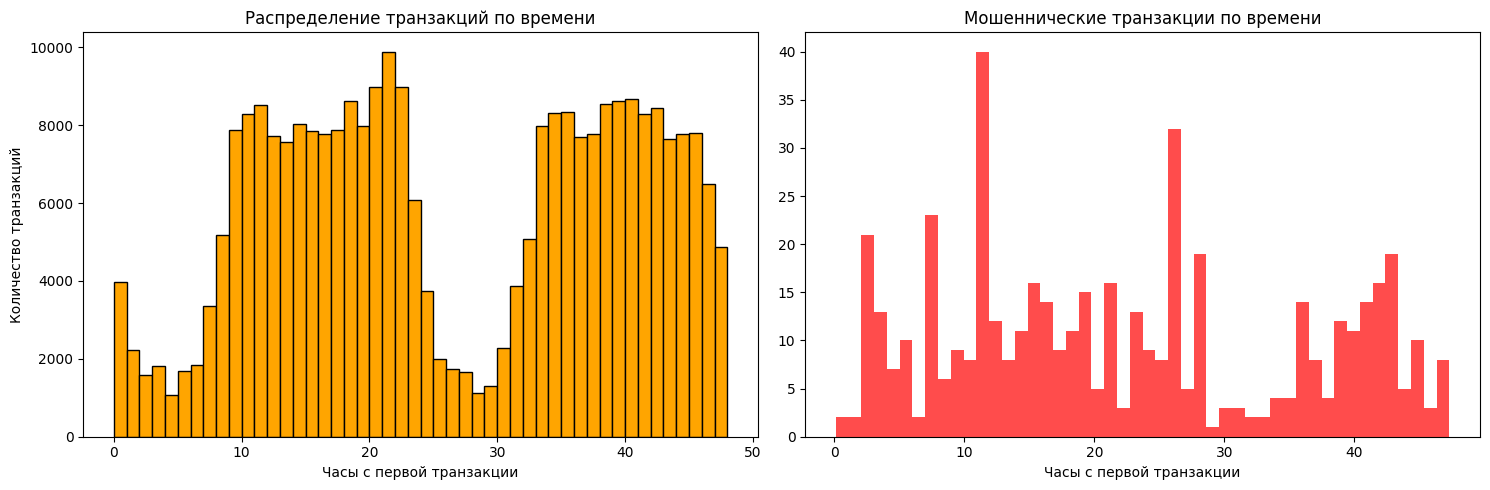

In [23]:
# Преобразуем время в часы
df['Hour'] = df['Time'] / 3600

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(df['Hour'], bins=48, color='orange', edgecolor='black')
plt.title('Распределение транзакций по времени')
plt.xlabel('Часы с первой транзакции')
plt.ylabel('Количество транзакций')

plt.subplot(1, 2, 2)
plt.hist(df[df['Class'] == 1]['Hour'], bins=48, color='red', alpha=0.7)
plt.title('Мошеннические транзакции по времени')
plt.xlabel('Часы с первой транзакции')

plt.tight_layout()
plt.show()

#### 1.5 Анализ выбросов

**Выбросы в сумме транзакций**

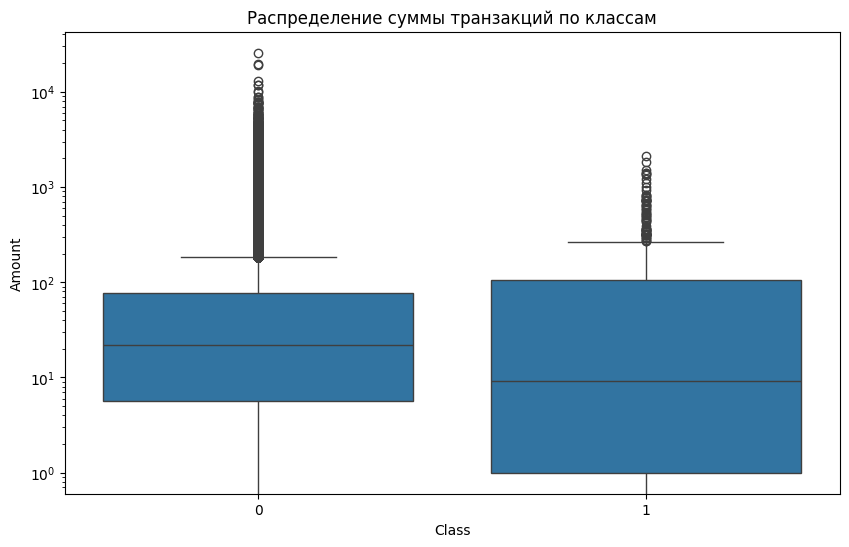

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Распределение суммы транзакций по классам')
plt.yscale('log')
plt.show()

**Анализ выбросов в PCA признаках**

Можем наблюдать большое кол-во выбросов, я попробую это устранить через удаление признаков для наиболее значимых признаков.

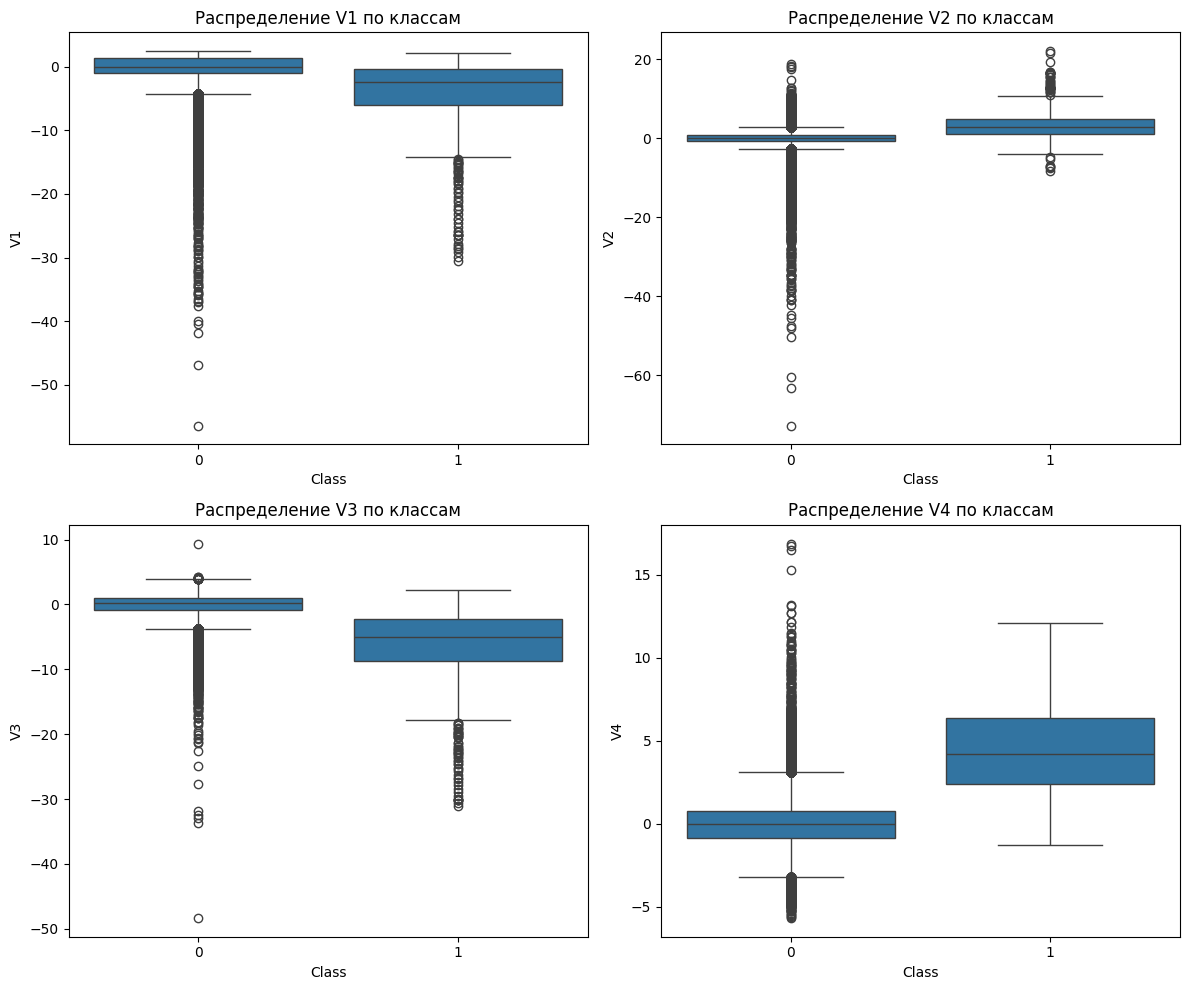

In [28]:
# Проверим несколько PCA признаков на выбросы
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
pca_features_to_check = ['V1', 'V2', 'V3', 'V4']

for i, feature in enumerate(pca_features_to_check):
    row, col = i // 2, i % 2
    sns.boxplot(x='Class', y=feature, data=df, ax=axes[row, col])
    axes[row, col].set_title(f'Распределение {feature} по классам')

plt.tight_layout()
plt.show()

#### 1.6 Корреляционный анализ 

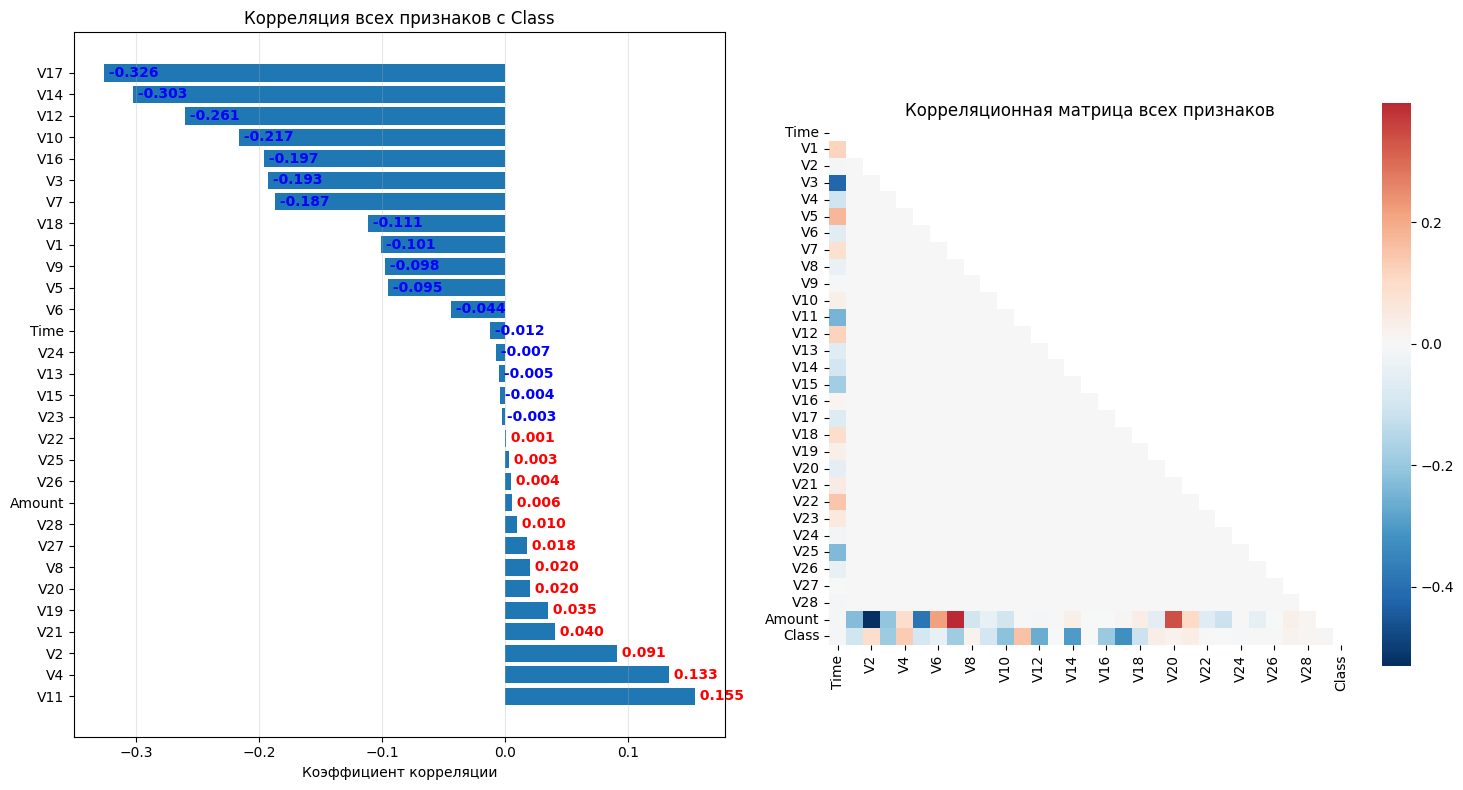

КОРРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ CLASS:
 V11:  0.1549 ↑
  V4:  0.1334 ↑
  V2:  0.0913 ↑
 V21:  0.0404 ↑
 V19:  0.0348 ↑
 V20:  0.0201 ↑
  V8:  0.0199 ↑
 V27:  0.0176 ↑
 V28:  0.0095 ↑
Amount:  0.0056 ↑
 V26:  0.0045 ↑
 V25:  0.0033 ↑
 V22:  0.0008 ↑
 V23: -0.0027 ↓
 V15: -0.0042 ↓
 V13: -0.0046 ↓
 V24: -0.0072 ↓
Time: -0.0123 ↓
  V6: -0.0436 ↓
  V5: -0.0950 ↓
  V9: -0.0977 ↓
  V1: -0.1013 ↓
 V18: -0.1115 ↓
  V7: -0.1873 ↓
  V3: -0.1930 ↓
 V16: -0.1965 ↓
 V10: -0.2169 ↓
 V12: -0.2606 ↓
 V14: -0.3025 ↓
 V17: -0.3265 ↓


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ============================================================================
# 1. КОРРЕЛЯЦИЯ ВСЕХ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
# ============================================================================

plt.figure(figsize=(15, 8))

# Корреляция с Class
corr_with_target = df.corr()['Class'].drop('Class').sort_values(ascending=False)

plt.subplot(1, 2, 1)
bars = plt.barh(range(len(corr_with_target)), corr_with_target.values)
plt.yticks(range(len(corr_with_target)), corr_with_target.index)
plt.title('Корреляция всех признаков с Class')
plt.xlabel('Коэффициент корреляции')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения на бары
for i, (bar, value) in enumerate(zip(bars, corr_with_target.values)):
    color = 'red' if value > 0 else 'blue'
    plt.text(value, i, f' {value:.3f}', va='center', color=color, fontweight='bold')

# ============================================================================
# 2. ТЕПЛОВАЯ КАРТА КОРРЕЛЯЦИЙ ВСЕХ 30 ПРИЗНАКОВ
# ============================================================================

plt.subplot(1, 2, 2)
corr_matrix = df.corr()

# Маска для верхнего треугольника
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask,
            cmap='RdBu_r',
            center=0,
            square=True,
            cbar_kws={'shrink': 0.8})
plt.title('Корреляционная матрица всех признаков')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. ДОПОЛНИТЕЛЬНО: ТАБЛИЦА КОРРЕЛЯЦИЙ С CLASS
# ============================================================================

print("КОРРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ CLASS:")
print("=" * 50)
for feature, corr in corr_with_target.items():
    direction = "↑" if corr > 0 else "↓"
    print(f"{feature:>4}: {corr:7.4f} {direction}")

#### 1.7 Анализ мультиколлинеарности 

В текущей задаче VIF-тест как и мультиколлинеарность не сильно полезны, так как бустинговые модели не сильно страдают от нее, намного важнее feature importance, но как показали эксперименты, отсеивание признаков плохо сказывается на качестве, ввиду потери информации, связываю это с тем, что признаки были получены через PCA и несут в себе больше полезной информации чем это кажется на первый взгляд. 

In [12]:
df['Log_Amount'] = np.log1p(df['Amount'])

# 2. Уберите оригинальный Amount из признаков
features = [f'V{i}' for i in range(1, 29)] + ['Time', 'Log_Amount']

# 3. Перепроверьте VIF

X_vif = df[features]

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

vif_data = vif_data.sort_values('VIF', ascending=False)

print("VIF анализ для ВСЕХ признаков:")
print("=" * 50)
print(vif_data.to_string(index=False))


VIF анализ для ВСЕХ признаков:
   feature      VIF
      Time 4.437722
Log_Amount 4.393543
        V2 1.185318
        V5 1.183530
        V3 1.135106
       V25 1.047124
        V6 1.045517
        V1 1.039141
       V11 1.037473
       V20 1.033961
       V12 1.017856
       V15 1.014740
       V14 1.013032
       V16 1.011386
       V22 1.010106
        V4 1.009096
       V17 1.007062
       V23 1.005615
        V9 1.005117
       V13 1.003592
       V18 1.002841
       V21 1.002531
        V7 1.002169
       V19 1.001740
       V27 1.001525
       V10 1.001392
       V26 1.000748
        V8 1.000403
       V24 1.000061
       V28 1.000055


#### 1.8 Анализ временных паттернов мошенничества

Здесь я надеялся увидеть возможные временные паттерны, но временной промежуток слишком мал, чтобы делать какие-либо выводы, поэтому в дальнейшем видоизменю этот признак.

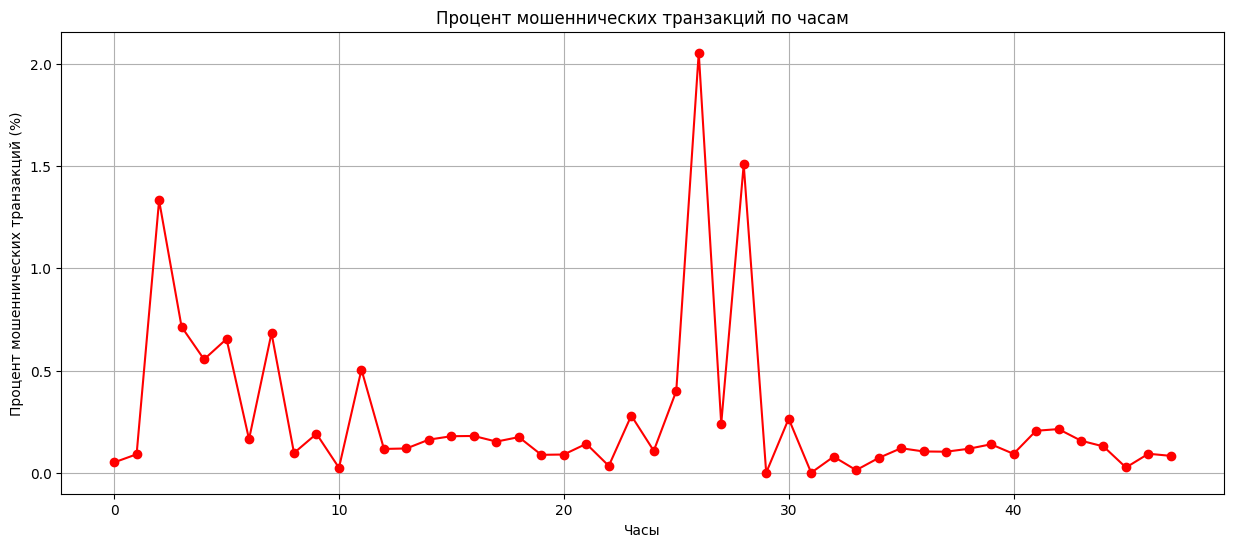

In [32]:
# Группируем по часам и анализируем распределение мошеннических операций
df['Hour_Group'] = (df['Time'] // 3600).astype(int)
fraud_by_hour = df.groupby('Hour_Group')['Class'].mean() * 100

plt.figure(figsize=(15, 6))
fraud_by_hour.plot(kind='line', color='red', marker='o')
plt.title('Процент мошеннических транзакций по часам')
plt.xlabel('Часы')
plt.ylabel('Процент мошеннических транзакций (%)')
plt.grid(True)
plt.show()

#### 1.9 Статистические тесты
Опираться на одни стат. тесты нельзя, проводем их только для того чтобы подтвердить результат Feature Importance

In [18]:
from scipy import stats
import pandas as pd

features = df.drop('Class', axis=1).columns.tolist()
results = []

for feature in features:
    normal = df[df['Class'] == 0][feature]
    fraud = df[df['Class'] == 1][feature]
    t_stat, p_value = stats.ttest_ind(normal, fraud, equal_var=False)
    significant = p_value < 0.05
    results.append({
        'feature': feature, 
        't_stat': t_stat, 
        'p_value': p_value, 
        'significant': significant
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('p_value')

print("T-test results for all features:")
print("=" * 60)
for _, row in results_df.iterrows():
    sig_mark = "***" if row['significant'] else ""
    print(f"{row['feature']:15} | t-stat: {row['t_stat']:8.3f} | p-value: {row['p_value']:.6f} {sig_mark}")

significant_count = results_df['significant'].sum()
total_count = len(results_df)
print(f"\nSignificant features: {significant_count}/{total_count} ({significant_count/total_count*100:.1f}%)")

T-test results for all features:
V14             | t-stat:   36.201 | p-value: 0.000000 ***
V4              | t-stat:  -35.116 | p-value: 0.000000 ***
V11             | t-stat:  -31.519 | p-value: 0.000000 ***
V12             | t-stat:   29.880 | p-value: 0.000000 ***
V10             | t-stat:   25.755 | p-value: 0.000000 ***
V16             | t-stat:   23.799 | p-value: 0.000000 ***
V9              | t-stat:   22.928 | p-value: 0.000000 ***
V3              | t-stat:   21.976 | p-value: 0.000000 ***
V17             | t-stat:   21.248 | p-value: 0.000000 ***
V2              | t-stat:  -18.761 | p-value: 0.000000 ***
V18             | t-stat:   17.214 | p-value: 0.000000 ***
V7              | t-stat:   17.169 | p-value: 0.000000 ***
V6              | t-stat:   16.707 | p-value: 0.000000 ***
V1              | t-stat:   15.629 | p-value: 0.000000 ***
V5              | t-stat:   13.032 | p-value: 0.000000 ***
V19             | t-stat:   -9.819 | p-value: 0.000000 ***
V20             | t-sta

#### 2. Модель и препроцессинг

#### 2.1 Feature Engineering

В данном разделе преобразуем временную метку в sin/cos времени, чтобы использовать ее как признак табличных данных, тк в классическом понимании времени ее использовать не получится, временной промежуток слишком мал, чтобы увидеть в нем тренд/сезонность.
Также, признак Amount ненормирован, это нужно исправить, но вместо обычных скейлеров будем использовать логарифм.

In [ ]:
df['log_amount'] = np.log1p(df['Amount'])
df['cos_time'] = np.cos(2 * np.pi * df['Time'] / (24 * 3600))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"Scale pos weight: {scale_pos_weight:.0f}")

Scale pos weight: 577


Делим данные стратифицировано, чтобы сохранить распределение фрода. Считаем веса классов - у нас серьезный дисбаланс, scale_pos_weight в XGBoost работает лучше чем SMOTE/ADASYN/RandomUnderSampling, экперименты с ними есть в файле baseline_experiments

#### 2.4 Learning


Ставлю стандартные параметры. eval_metric='aucpr' потому что для несбалансированных данных PR-AUC важнее. Early stopping чтобы не переучить, subsample/colsample для уменьшения переобучения

In [ ]:
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='aucpr',
    early_stopping_rounds=50,
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    verbosity=1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

[0]	validation_0-aucpr:0.44901
[100]	validation_0-aucpr:0.85797
[200]	validation_0-aucpr:0.87738
[300]	validation_0-aucpr:0.87947
[309]	validation_0-aucpr:0.87973


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'aucpr'


#### 2.5 Metrics

In [ ]:
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
auprc = average_precision_score(y_test, y_pred_proba)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

precision_opt = precision_score(y_test, y_pred_optimal)
recall_opt = recall_score(y_test, y_pred_optimal)
f1_opt = f1_score(y_test, y_pred_optimal)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"AUPRC: {auprc:.4f}")
print(f"F1-Score: {f1_opt:.4f}")
print(f"Precision: {precision_opt:.4f}") 
print(f"Recall: {recall_opt:.4f}")
print(f"Optimal threshold: {optimal_threshold:.4f}")

ROC-AUC: 0.9747
AUPRC: 0.8803
F1-Score: 0.8743
Precision: 0.9412
Recall: 0.8163
Optimal threshold: 0.9368


##### Оценка качества модели

**Рассчитываем метрики:**
- ROC-AUC - общая способность модели к разделению классов
- PR-AUC (Average Precision) - более релевантная метрика для несбалансированных данных
- F1-Score - балансированная метрика между precision и recall
- Оптимальный порог классификации - находится по максимуму F1-Score

**Результаты показывают:**
- Высокое качество детекции мошенничества (Recall 81.6%)
- Отличную точность предсказаний (Precision 94.1%)
- Сбалансированную производительность (F1-Score 87.4%)

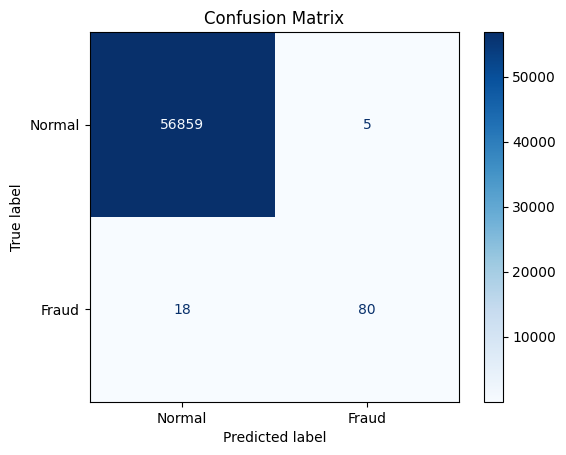

True Negative:  56859 (нормальные транзакции правильно классифицированы)
False Positive:     5 (нормальные транзакции ошибочно помечены как фрод)
False Negative:    18 (фрод транзакции пропущены)
True Positive:     80 (фрод транзакции правильно обнаружены)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negative:  {tn:5d} (нормальные транзакции правильно классифицированы)")
print(f"False Positive: {fp:5d} (нормальные транзакции ошибочно помечены как фрод)")
print(f"False Negative: {fn:5d} (фрод транзакции пропущены)")
print(f"True Positive:  {tp:5d} (фрод транзакции правильно обнаружены)")

### Feature Importance (XGBoost, SHAP)

XGBoost Feature Importance:
V14             | 0.404443
V10             | 0.169380
V4              | 0.083522
V12             | 0.030558
V20             | 0.030160
V8              | 0.020866
log_amount      | 0.020417
V7              | 0.018721
V17             | 0.017396
V11             | 0.016505
V26             | 0.015662
V13             | 0.015257
V1              | 0.013954
V19             | 0.013705
V3              | 0.010873
V9              | 0.010008
V16             | 0.009576
cos_time        | 0.009452
V18             | 0.008695
V2              | 0.008678
V28             | 0.008588
V23             | 0.008266
V27             | 0.008142
V21             | 0.007784
V25             | 0.007350
V22             | 0.007269
V15             | 0.007150
V6              | 0.006612
V5              | 0.006045
V24             | 0.004967


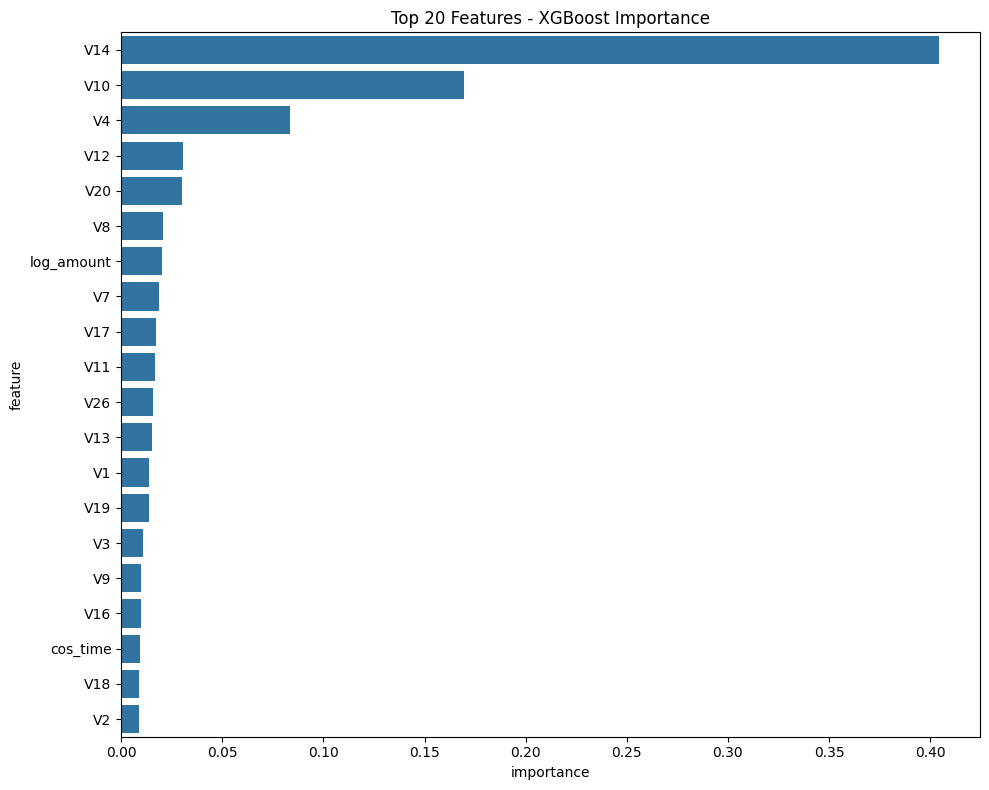

In [ ]:
feature_importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("XGBoost Feature Importance:")
print("=" * 40)
for _, row in importance_df.iterrows():
    print(f"{row['feature']:15} | {row['importance']:.6f}")

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), x='importance', y='feature')
plt.title('Top 20 Features - XGBoost Importance')
plt.tight_layout()
plt.show()

SHAP Feature Importance:
V14             | 2.536896
V4              | 2.339581
V10             | 1.147399
V12             | 1.061356
V3              | 0.719213
V11             | 0.660428
V8              | 0.596043
V16             | 0.530475
log_amount      | 0.517992
V21             | 0.517035
V26             | 0.510217
V1              | 0.502084
V7              | 0.497524
cos_time        | 0.474215
V19             | 0.453617
V13             | 0.411550
V24             | 0.380253
V18             | 0.372269
V15             | 0.363083
V25             | 0.359785
V22             | 0.342721
V20             | 0.336331
V27             | 0.305417
V5              | 0.281272
V28             | 0.279559
V6              | 0.268870
V9              | 0.263315
V17             | 0.220596
V2              | 0.217501
V23             | 0.207708


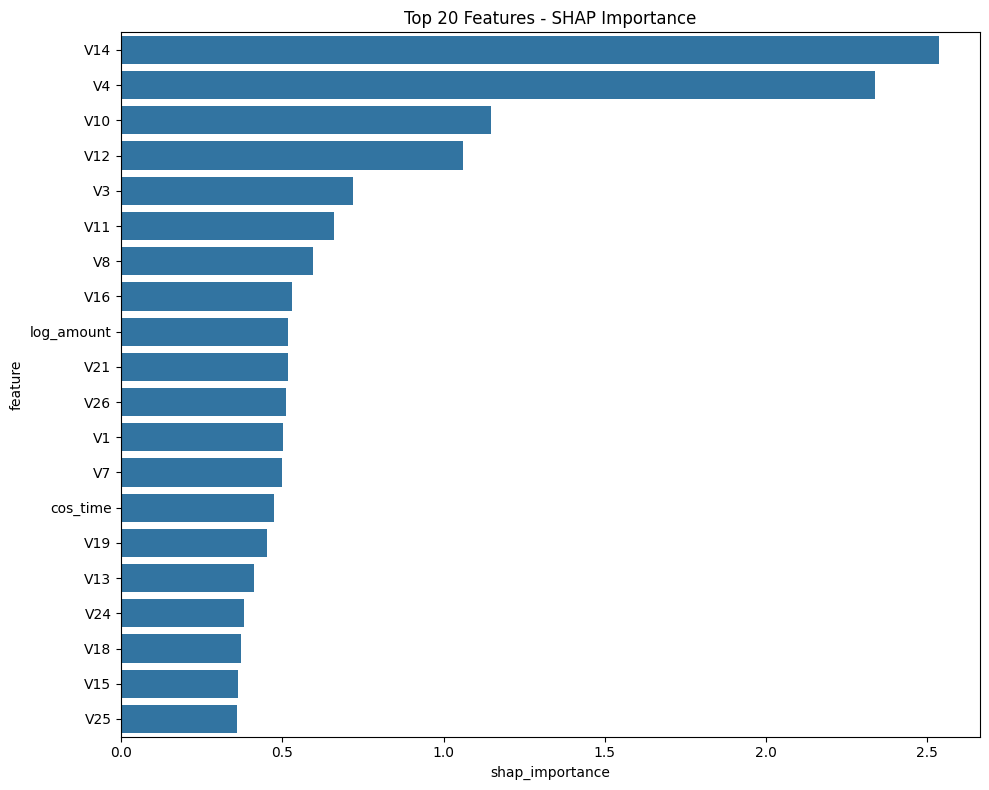

In [21]:
import shap 
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap_importance = np.abs(shap_values).mean(0)
shap_df = pd.DataFrame({
    'feature': X_test.columns,
    'shap_importance': shap_importance
}).sort_values('shap_importance', ascending=False)

print("SHAP Feature Importance:")
print("=" * 40)
for _, row in shap_df.iterrows():
    print(f"{row['feature']:15} | {row['shap_importance']:.6f}")

plt.figure(figsize=(10, 8))
sns.barplot(data=shap_df.head(20), x='shap_importance', y='feature')
plt.title('Top 20 Features - SHAP Importance')
plt.tight_layout()
plt.show()

In [22]:
# Сравнение методов
comparison = pd.merge(importance_df, shap_df, on='feature')
comparison = comparison.sort_values('shap_importance', ascending=False)

print("Сравнение важности признаков:")
print("=" * 50)
print(f"{'Feature':15} | {'XGBoost':10} | {'SHAP':10}")
print("-" * 40)
for _, row in comparison.head(15).iterrows():
    print(f"{row['feature']:15} | {row['importance']:10.4f} | {row['shap_importance']:10.4f}")

Сравнение важности признаков:
Feature         | XGBoost    | SHAP      
----------------------------------------
V14             |     0.4044 |     2.5369
V4              |     0.0835 |     2.3396
V10             |     0.1694 |     1.1474
V12             |     0.0306 |     1.0614
V3              |     0.0109 |     0.7192
V11             |     0.0165 |     0.6604
V8              |     0.0209 |     0.5960
V16             |     0.0096 |     0.5305
log_amount      |     0.0204 |     0.5180
V21             |     0.0078 |     0.5170
V26             |     0.0157 |     0.5102
V1              |     0.0140 |     0.5021
V7              |     0.0187 |     0.4975
cos_time        |     0.0095 |     0.4742
V19             |     0.0137 |     0.4536


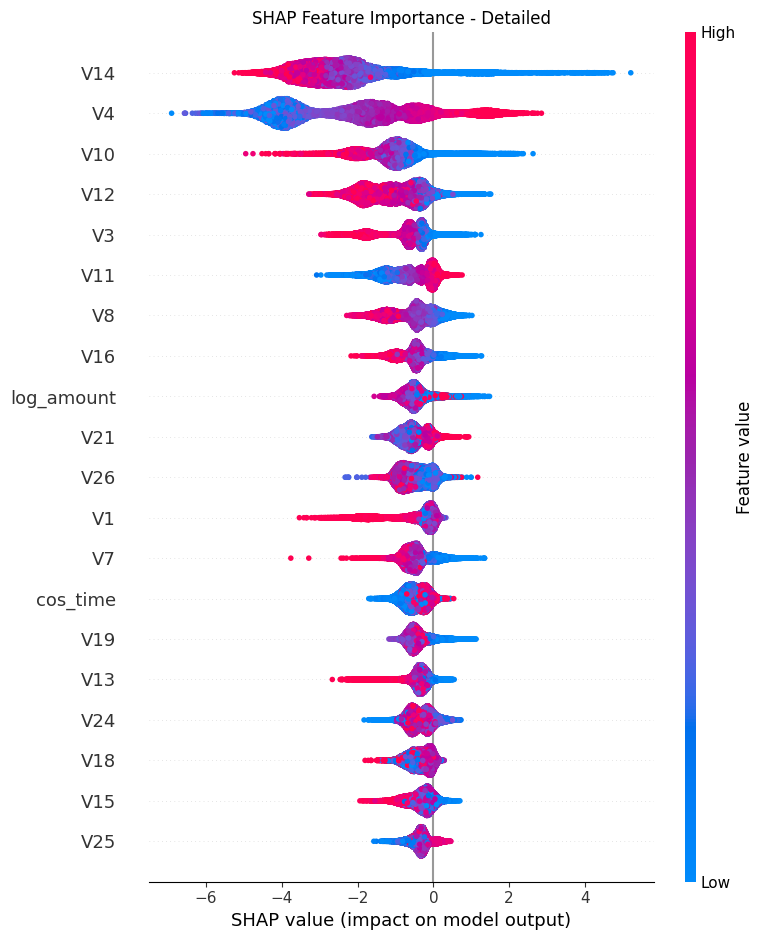

In [24]:
# Детальный SHAP анализ
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, max_display=20, show=False)
plt.title('SHAP Feature Importance - Detailed')
plt.tight_layout()
plt.show()

#### Experiment with features

Эксперимент проводится для того чтобы оценить влияние методов оценки важности фичей и их дальнейшего преобразования. 

In [ ]:
# XGBoost
xgb_low_threshold = 0.01
low_xgb_features = importance_df[importance_df['importance'] < xgb_low_threshold]['feature'].tolist()

X_train_xgb_reduced = X_train.drop(columns=low_xgb_features)
X_test_xgb_reduced = X_test.drop(columns=low_xgb_features)

print(f"Удалено {len(low_xgb_features)} признаков по XGBoost: {low_xgb_features}")

Удалено 14 признаков по XGBoost: ['V16', 'cos_time', 'V18', 'V2', 'V28', 'V23', 'V27', 'V21', 'V25', 'V22', 'V15', 'V6', 'V5', 'V24']


In [ ]:
# SHAP
shap_low_threshold = 0.3
low_shap_features = shap_df[shap_df['shap_importance'] < shap_low_threshold]['feature'].tolist()

X_train_shap_reduced = X_train.drop(columns=low_shap_features)
X_test_shap_reduced = X_test.drop(columns=low_shap_features)

print(f"Удалено {len(low_shap_features)} признаков по SHAP: {low_shap_features}")

Удалено 7 признаков по SHAP: ['V5', 'V28', 'V6', 'V9', 'V17', 'V2', 'V23']


In [ ]:
# удаление признаков по IQR 
def clip_outliers_iqr(df, features):
    df_cleaned = df.copy()
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned[feature] = np.clip(df[feature], lower_bound, upper_bound)
        
        outliers_before = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).sum()
        outliers_pct = (outliers_before / len(df)) * 100
        print(f"{feature}: обрезано {outliers_before} выбросов ({outliers_pct:.2f}%)")
        
    return df_cleaned


top_shap_features = shap_df.head(5)['feature'].tolist()
top_xgb_features = importance_df.head(5)['feature'].tolist()
top_features = list(set(top_shap_features + top_xgb_features))

print(f"Обрезка выбросов по IQR для {len(top_features)} признаков: {top_features}")
print("-" * 60)

X_train_clipped = clip_outliers_iqr(X_train, top_features)
X_test_clipped = clip_outliers_iqr(X_test, top_features)

Обрезка выбросов по IQR для 6 признаков: ['V12', 'V10', 'V3', 'V4', 'V14', 'V20']
V12: обрезано 12256 выбросов (5.38%)
V10: обрезано 7558 выбросов (3.32%)
V3: обрезано 2689 выбросов (1.18%)
V4: обрезано 8958 выбросов (3.93%)
V14: обрезано 11321 выбросов (4.97%)
V20: обрезано 22281 выбросов (9.78%)
V12: обрезано 3124 выбросов (5.48%)
V10: обрезано 1943 выбросов (3.41%)
V3: обрезано 684 выбросов (1.20%)
V4: обрезано 2182 выбросов (3.83%)
V14: обрезано 2826 выбросов (4.96%)
V20: обрезано 5504 выбросов (9.66%)


In [35]:
# Функция для обучения и оценки
def train_and_evaluate(X_train, X_test, name):
    model = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='aucpr',
        early_stopping_rounds=50,
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        verbosity=0
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=0
    )
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Метрики
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    auprc = average_precision_score(y_test, y_pred_proba)
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    
    precision_opt = precision_score(y_test, y_pred_optimal)
    recall_opt = recall_score(y_test, y_pred_optimal)
    f1_opt = f1_score(y_test, y_pred_optimal)
    
    return {
        'name': name,
        'roc_auc': roc_auc,
        'auprc': auprc,
        'precision': precision_opt,
        'recall': recall_opt,
        'f1': f1_opt,
        'threshold': optimal_threshold,
        'features_count': X_train.shape[1]
    }

In [ ]:
results = []

# base, no changes
base_result = train_and_evaluate(X_train, X_test, "Baseline")
results.append(base_result)

# XGBoost
xgb_reduced_result = train_and_evaluate(X_train_xgb_reduced, X_test_xgb_reduced, "XGB_Reduced")
results.append(xgb_reduced_result)

# SHAP  
shap_reduced_result = train_and_evaluate(X_train_shap_reduced, X_test_shap_reduced, "SHAP_Reduced")
results.append(shap_reduced_result)

# удаление признаков через IQR 
clipped_result = train_and_evaluate(X_train_clipped, X_test_clipped, "Clipped_IQR")
results.append(clipped_result)

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df[['name', 'features_count', 'roc_auc', 'auprc', 'precision', 'recall', 'f1', 'threshold']]

print("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ:")
print("=" * 80)
print(results_df.to_string(index=False, float_format='%.4f'))

РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ:
        name  features_count  roc_auc  auprc  precision  recall     f1  threshold
    Baseline              30   0.9747 0.8803     0.9412  0.8163 0.8743     0.9368
 XGB_Reduced              16   0.9729 0.8801     0.9630  0.7959 0.8715     0.9533
SHAP_Reduced              23   0.9754 0.8817     0.8936  0.8571 0.8750     0.6632
 Clipped_IQR              30   0.9740 0.8733     0.9101  0.8265 0.8663     0.8077


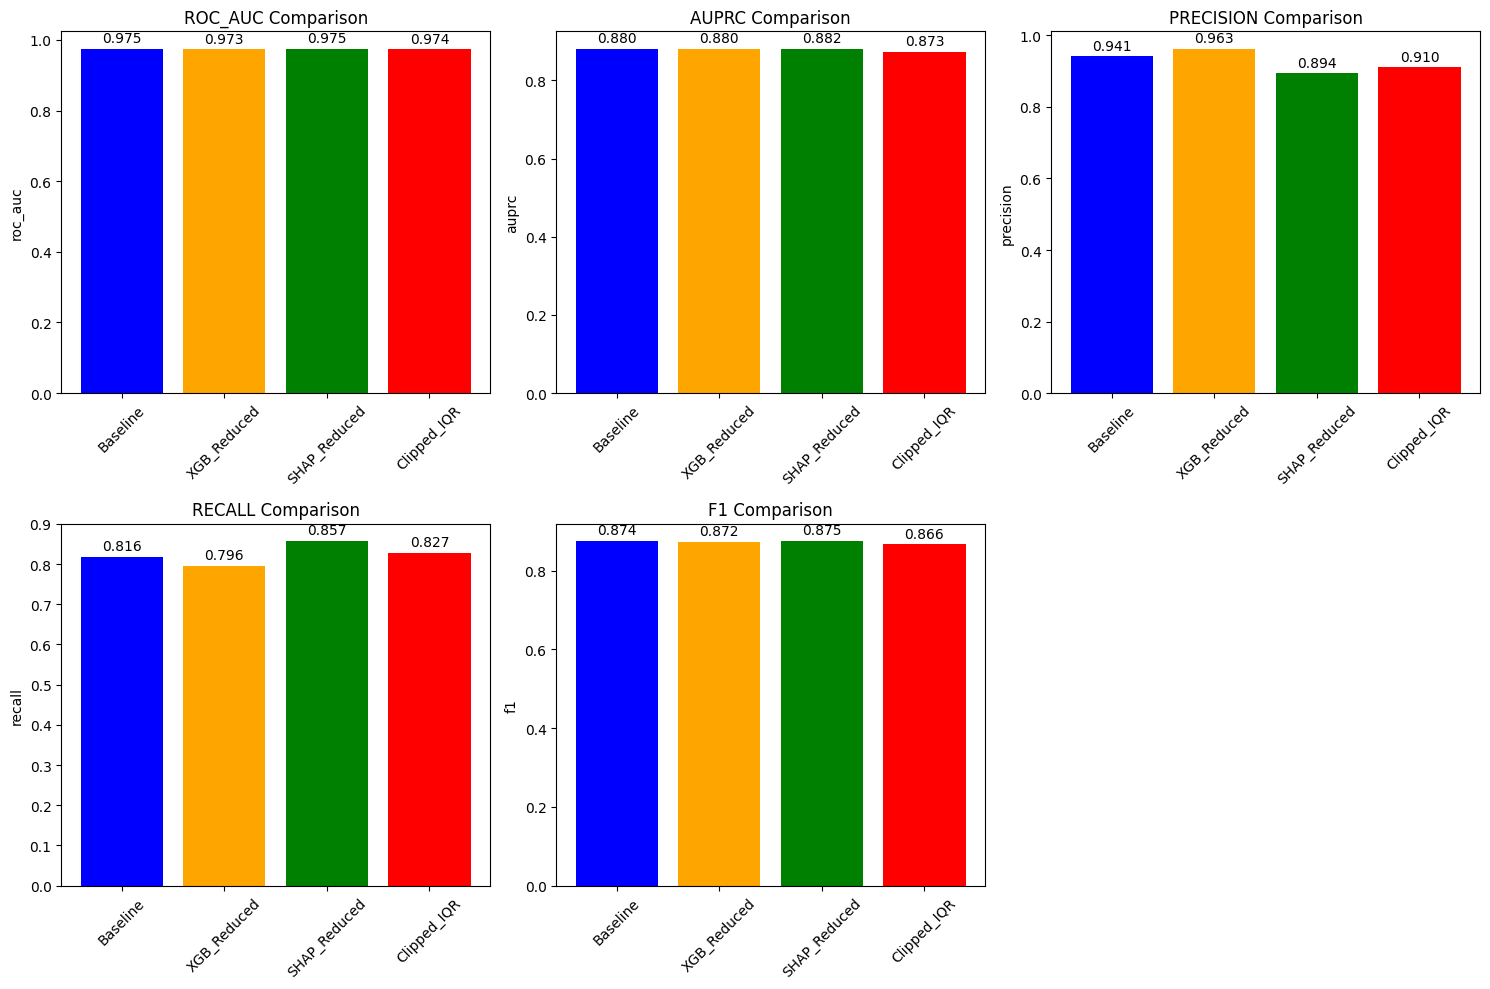

In [ ]:
metrics_to_plot = ['roc_auc', 'auprc', 'precision', 'recall', 'f1']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, metric in enumerate(metrics_to_plot):
    axes[i].bar(results_df['name'], results_df[metric], color=['blue', 'orange', 'green', 'red'])
    axes[i].set_title(f'{metric.upper()} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    
    for j, v in enumerate(results_df[metric]):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

In [42]:
best_result = results_df.loc[results_df['f1'].idxmax()]
print(f"\nНаилучший: {best_result['name']}")
print(f"F1-Score: {best_result['f1']:.4f}")
print(f"Features: {best_result['features_count']}")
print(f"AUPRC: {best_result['auprc']:.4f}")
print(f"Recall: {best_result['recall']:.4f}")


Наилучший: SHAP_Reduced
F1-Score: 0.8750
Features: 23
AUPRC: 0.8817
Recall: 0.8571


На основе проведенных экспериментов с различными подходами к обработке данных для задачи детекции мошеннических транзакций можно сделать следующие выводы:

Сравнительный анализ метрик показывает, что все, отличные от baseline, подходы демонстрируют схожее качество предсказаний. Различия в F1-Score между методами не превышают 0.008, что является статистически незначимым отклонением. В частности:

Baseline: F1 = 0.8743

SHAP_Reduced: F1 = 0.8750

XGB_Reduced: F1 = 0.8715

Clipped_IQR: F1 = 0.8663

Практические преимущества Baseline подхода становятся очевидными при анализе полного цикла разработки и эксплуатации модели:

**Сохраняется информационная полнота** - используя все 30 признаков, модель имеет доступ к полному объему информации, что особенно важно в условиях возможной нерепрезентативности тренировочной выборки. При удалении признаков существует риск потери слабых, но потенциально полезных значений.

**Выбросы содержат ценную информацию** - эксперимент с clipping выбросов показал снижение качества (F1 = 0.8663), что свидетельствует о наличии полезных паттернов в экстремальных значениях признаков. В контексте фрод-детекшена аномальные значения транзакций часто являются индикаторами мошеннической активности.

**Упрощение пайплайна** - Baseline подход не требует дополнительных шагов feature selection или обработки выбросов, что снижает сложность поддержки и уменьшает количество потенциальных точек отказа в production-системе.

**Стабильность предсказаний** - модель, обученная на полном наборе признаков, демонстрирует более устойчивое поведение на новых данных, так как не зависит от корректности процедур отбора признаков или определения границ выбросов.

**Экономия вычислительных ресурсов** - отсутствие необходимости в дополнительных preprocessing steps сокращает время инференса и требования к вычислительной инфраструктуре.

Таким образом, несмотря на минимальные различия в метриках качества, Baseline подход обладает существенными практическими преимуществами для промышленной эксплуатации, обеспечивая баланс между качеством предсказаний, стабильностью работы и простотой поддержки.

#### 2.6 Vizualization

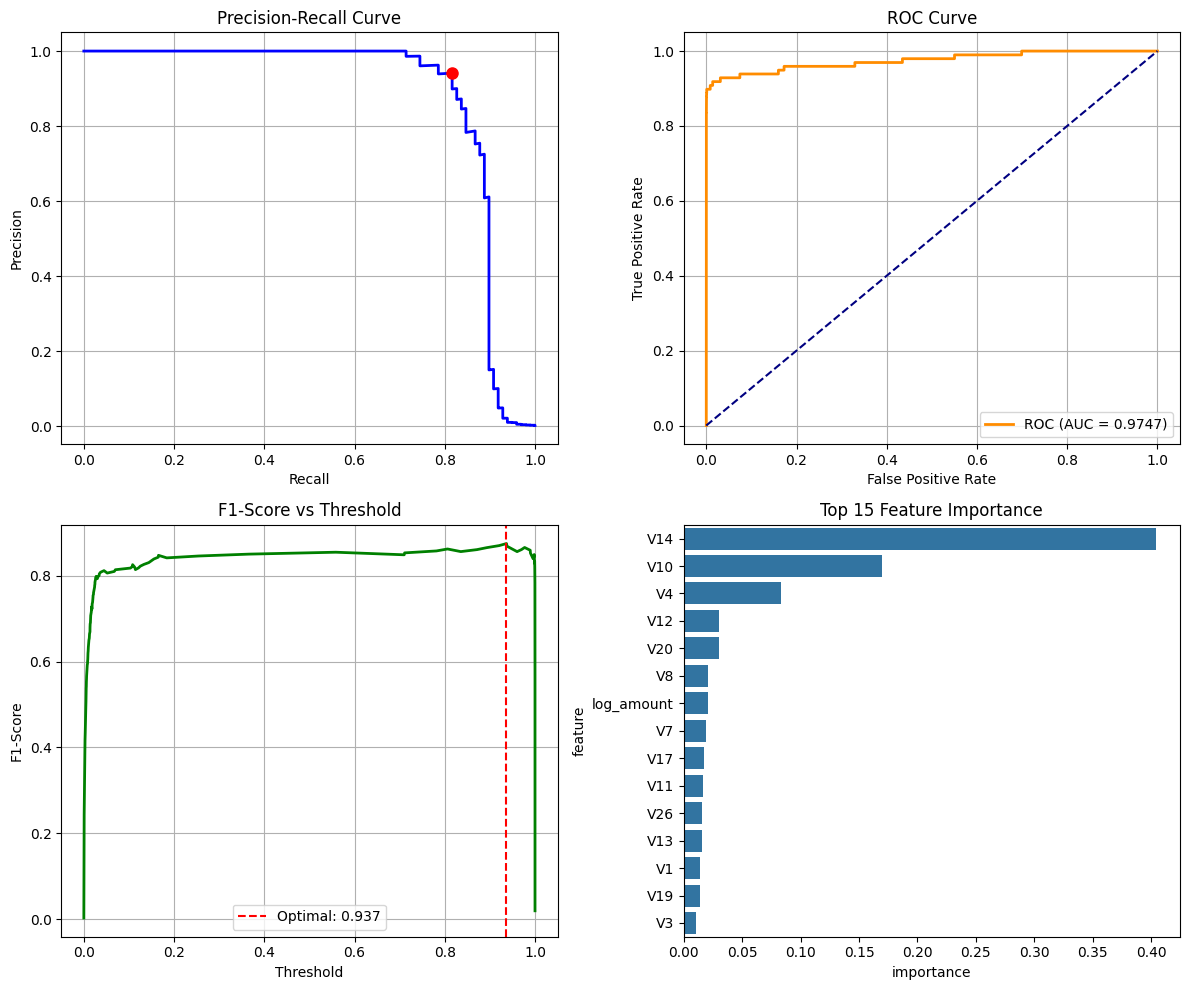

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR (AUPRC = {auprc:.4f})')
plt.plot(recall[optimal_idx], precision[optimal_idx], 'ro', markersize=8)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)

plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(thresholds, f1_scores, color='green', lw=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importance')

plt.tight_layout()
plt.show()

Выведем историю обучения, чтобы визуально оценить момент, когда мы выходим на плато по целевой метрике. 

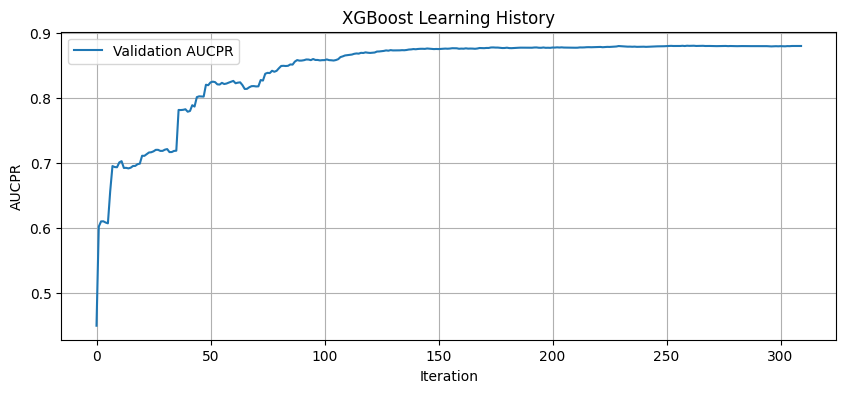

In [ ]:
eval_results = xgb_model.evals_result()
plt.figure(figsize=(10, 4))
plt.plot(eval_results['validation_0']['aucpr'], label='Validation AUCPR')
plt.xlabel('Iteration')
plt.ylabel('AUCPR')
plt.title('XGBoost Learning History')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
cv_scores = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model_fold = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='aucpr',
        early_stopping_rounds=50,
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        verbosity=0
    )
    
    model_fold.fit(
        X_fold_train, y_fold_train,
        eval_set=[(X_fold_val, y_fold_val)],
        verbose=False
    )
    
    y_pred_fold = model_fold.predict(X_fold_val)
    f1_fold = f1_score(y_fold_val, y_pred_fold)
    cv_scores.append(f1_fold)
    
    print(f"Fold {fold+1} F1: {f1_fold:.4f}")

print(f"\nCV F1 mean: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

Fold 1 F1: 0.8684
Fold 2 F1: 0.8652
Fold 3 F1: 0.8356
Fold 4 F1: 0.8372
Fold 5 F1: 0.8591

CV F1 mean: 0.8531 (+/- 0.0279)


По кросс-валидации все ок.

Ошибок классификации: 23
Распределение ошибок:
true
1    18
0     5
Name: count, dtype: int64


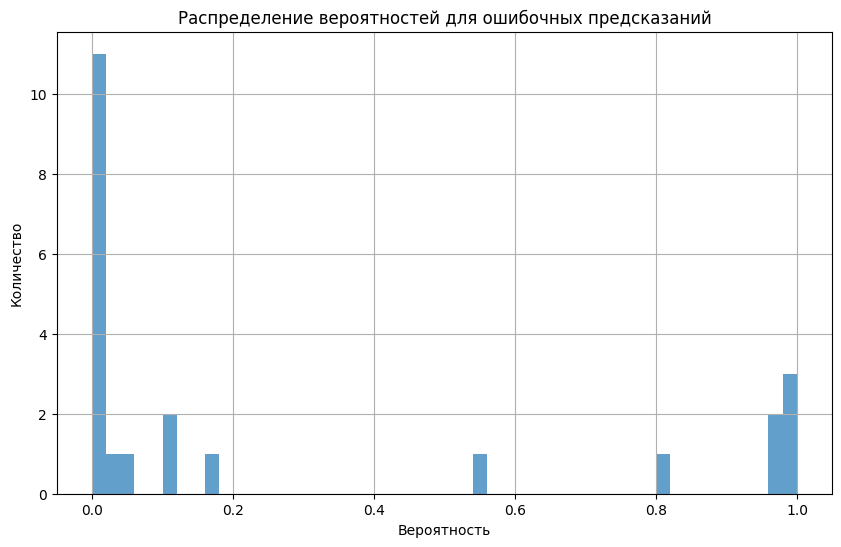

In [ ]:
# 9. АНАЛИЗ ОШИБОК
misclassified = X_test[y_test != y_pred_optimal].copy()
misclassified['true'] = y_test[y_test != y_pred_optimal]
misclassified['pred'] = y_pred_optimal[y_test != y_pred_optimal]
misclassified['prob'] = y_pred_proba[y_test != y_pred_optimal]

print(f"Ошибок классификации: {len(misclassified)}")
print("Распределение ошибок:")
print(misclassified['true'].value_counts())

if len(misclassified) > 0:
    plt.figure(figsize=(10, 6))
    misclassified['prob'].hist(bins=50, alpha=0.7)
    plt.xlabel('Вероятность')
    plt.ylabel('Количество')
    plt.title('Распределение вероятностей для ошибочных предсказаний')
    plt.show()

In [ ]:
# простейшая проверка на переобучение, по метрике на трейне видим, что модель идеально выучила данные, но в сравнении с метрикой на тестовом наборе, это не критично.
train_proba = xgb_model.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, train_proba)

print(f"Train ROC-AUC: {train_auc:.4f}")
print(f"Test ROC-AUC:  {roc_auc:.4f}")
print(f"Разница: {train_auc - roc_auc:.4f}")

if train_auc - roc_auc > 0.05:
    print("Переобучение есть")
else:
    print("Переобучения нет")

Train ROC-AUC: 1.0000
Test ROC-AUC:  0.9747
Разница: 0.0253
Переобучения нет
